# Google Earth Engine Variable Extraction Notebook

This notebook provides functions to extract various environmental variables from Google Earth Engine (GEE) datasets.
The primary goals are:
- Define functions to retrieve specific variables based on user-defined parameters (region, time period, frequency).
- For time-series data, aggregate it to hourly, daily, monthly, or yearly means.
- Save the extracted data for each variable into a separate CSV file.

**Instructions:**
1. Run the GEE Authentication and Initialization cell first. You will need to authenticate with a Google account that has GEE access.
2. Define your region of interest (AOI) as a GeoJSON-like dictionary.
3. Call the specific extraction functions for the variables you need, providing the AOI, date range, frequency, and output directory.

In [54]:
# CONFIG VALUES

# BELA BELA -24.868138, 28.374596
# Zona sin vegetacion '''24°52'48"S 28°24'43"E'''  '''24°52'37"S 28°24'07"E'''
# Zona con vegetacion '''24°52'12"S 28°22'26"E'''

# AlHenakiyah (SaudiArabia)
# 24.52594, 40.74656

# Phofu sitio (poca vegetacion, sin arboles)
# '''27°07'51"S 26°47'53"E'''
# 27°04'47"S 26°52'12"E
# Vierfontein, South Africa
# '''-27.0844° 26.8722'''
# '''27°05'01"S 26°52'18"E'''

# Onderstepoort Cluster Site
# '''25°26'05"S 27°01'07"E'''

# El Sanate (Guatemala)
# '''14.02 N -90.37 W'''

# Valle 1-4
# ''' 41°41'49"N 4°54'30"W'''


# Corbii
# '''44°30'21"N 25°28'37"E'''

# Peñaflor
# '''41°46'14"N 0°25'09"W'''
# Nimbo
# '''40°21'20"N 3°26'07"W'''
# Pinon
# '''40°23'30"N 3°15'35"W'''

# Dwaalboom Site
#'''24°56'49"S 27°18'32"E'''
#'''25°26'42"S 26°58'02"E'''

# Hysencia
# '''42°13'01"N 0°33'55"W'''


# Rodas
# '''10°25'11"N 73°13'11"W'''

# Tenerife (Colombia)
# 10°34'12"N 75°21'35"W

# Quiquima (España)
# 37°28'24"N 2°40'15"W

# Doral Morocco
# 32°52'11"N 7°03'35"W

# DEWA
# 24°42'50"N 55°26'57"E
# displaced
# 24°40'59"N 55°29'04"E

# Barbados Colombia
# 5°35'01"N 73°34'42"W

# Klip Punt, South Africa
# - Location A-1
#     - Latitude: 28°30'51.48"S
#     - Longitude: 21°1'58.44"E
#     - Ground Surface: Natural

# - Location A-2
#     - Latitude: 28°30'50.94"S
#     - Longitude: 21°1'57.48"E
#     - Ground Surface: Brush-cut

# - Location B-1
#     - Latitude: 28°30'43.86"S
#     - Longitude: 21°2'50.22"E
#     - Ground Surface: Natural

# - Location B-2
#     - Latitude: 28°30'43.68"S
#     - Longitude: 21°2'48.96"E
#     - Ground Surface: Brush-cut

# - Location C-1
#     - Latitude: 28°32'13.44"S
#     - Longitude: 21°3'37.44"E
#     - Ground Surface: Natural

# - Location C-2
#     - Latitude: 28°32'12.66"S
#     - Longitude: 21°3'39.00"E
#     - Ground Surface: Brush-cut


# GSD2-Infinity Power Ngwedi_QC
#     - Latitude: -25.447719
#     - Longitude: 27.021099

## Cobra
# PVSP_Murcia 1_Cobra
#  - Latitude: 37.970000
#  - Longitude:-1.390000

## PVSP_Requena P1_2
#  - Latitude: 39.370000
#  - Latitude: -1.110000

# PVSP_Teruel_P123
#  - Latitude: 41.250000
#  - Latitude: -0.280000


# Location
LOCATION_NAME = 'PVSP_Requena1_2_Cobra (Spain)'
LATITUDE = '''39.370000'''
LONGITUDE =  '''-1.110000'''
DESCRIPCION = 'Ground Albedo 500m radio'

# Area of interest
POLIGON_VERTICES = 6
RADIO = 0.5 # Kilometers

# PERIOD

# historical data
INITIAL_DATE = '2001-01-01'
FINAL_DATE = '2023-11-30'

# INITIAL_DATE = '2021-06-01'
# FINAL_DATE = '2021-06-30'
# Define the desired frequency for time-series aggregation in csv file
# Options: 'hourly', 'daily', 'monthly', 'yearly'
FRECUENCY = 'daily'



# GEE project
PROJECT='gen-lang-client-0253961861'

In [32]:
# Run this once per session
# Update folium to latest version

!sudo apt-get install wkhtmltopdf
!pip install folium html2image
!pip install --upgrade folium
!pip install playwright
!playwright install
!pip install reportlab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wkhtmltopdf is already the newest version (0.12.6-2).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                

In [33]:
import ee
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import os
import csv
import math # Ensure math is imported for potential calculations like wind
import calendar

In [34]:
# Trigger the authentication flow.
# This will print a URL, open it, authorize, and copy the code back into the input box.
try:
    ee.Authenticate()
except Exception as e:
    print(f"Authentication failed or already authenticated: {e}")
    # For automated environments or if auth was done in a previous session,
    # this might raise an error if not needed, so we can often proceed.

# Initialize the library.
# Replace 'YOUR_GEE_PROJECT' with your actual GEE project ID if you have one,
# otherwise, GEE often can use a default cloud project associated with your account.
try:
    ee.Initialize(project='gen-lang-client-0253961861')
    print("GEE Initialized successfully.")
except Exception as e:
    try:
        # Fallback if project-specific initialization fails
        ee.Initialize()
        print("GEE Initialized successfully (default project).")
    except Exception as e_init:
        print(f"GEE Initialization failed: {e_init}")
        print("Please ensure you have authenticated and have a GEE-enabled project.")

# Define a helper to check GEE initialization status
def check_gee_initialized():
    try:
        ee.ImageCollection('MODIS/061/MCD43A3').limit(1).size().getInfo()
        print("GEE is initialized and accessible.")
        return True
    except Exception as e:
        print(f"GEE not properly initialized or accessible: {e}")
        return False

check_gee_initialized()

GEE Initialized successfully.
GEE is initialized and accessible.


True

In [35]:
# Generic Time Series Extraction Function
def extract_gee_time_series(
    variable_name: str,
    region_geojson: dict, # GeoJSON dictionary for the region
    start_date_str: str,
    end_date_str: str,
    frequency: str,  # 'hourly', 'daily', 'monthly', 'yearly'
    gee_dataset_id: str,
    gee_band_name: str, # Can be a list for multi-band calculations (e.g. wind)
    scale: int,
    output_dir: str,
    gee_project: str = None, # Optional: GEE project for initialization if needed
    reducer: ee.Reducer = ee.Reducer.mean(),
    data_scaling_factor: float = None,
    data_offset_factor: float = None,
    post_process_function: callable = None, # Function to apply to the reduced value or dictionary of values
    nan_value = None # Value to use if GEE returns None
) -> str:
    """
    Extracts time-series data from Google Earth Engine for a specified variable and frequency,
    saves it to a CSV file, and returns the path to the CSV.

    Parameters:
    - variable_name: Name of the variable (used for CSV filename).
    - region_geojson: GeoJSON dictionary defining the region of interest.
    - start_date_str: Start date in 'YYYY-MM-DD' format.
    - end_date_str: End date in 'YYYY-MM-DD' format.
    - frequency: Aggregation frequency ('hourly', 'daily', 'monthly', 'yearly').
    - gee_dataset_id: Earth Engine ImageCollection ID.
    - gee_band_name: Name of the band(s) to extract. If a list, post_process_function must handle it.
    - scale: Spatial resolution in meters for reduction.
    - output_dir: Directory to save the output CSV file.
    - gee_project: Optional GEE project ID for ee.Initialize().
    - reducer: Earth Engine reducer to apply (default: ee.Reducer.mean()).
    - data_scaling_factor: Optional factor to multiply the band data by.
    - data_offset_factor: Optional offset to add to the band data.
    - post_process_function: Optional function to apply to the raw reduced value(s).
                             It should accept a dictionary of band values if multiple bands are processed,
                             or a single value if one band is processed. It should return a dictionary
                             of processed values or a single processed value.
    - nan_value: Value to fill in if GEE returns no data for a period.

    Returns:
    - Path to the generated CSV file.
    """
    if gee_project:
        try:
            ee.Initialize(project=gee_project)
        except Exception:
            ee.Initialize() # Fallback

    ee_region = ee.Geometry(region_geojson)

    start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

    os.makedirs(output_dir, exist_ok=True)

    date_periods = []
    current_date = start_date

    if frequency == 'hourly':
        delta = relativedelta(hours=1)
        date_format_label = '%Y-%m-%d %H:%M:%S'
        while current_date <= end_date:
            period_end_date = current_date + delta - relativedelta(seconds=1) # End of the hour
            date_periods.append({
                "start": current_date.strftime('%Y-%m-%dT%H:%M:%S'),
                "end": period_end_date.strftime('%Y-%m-%dT%H:%M:%S'),
                "label": current_date.strftime(date_format_label)
            })
            current_date += delta
    elif frequency == 'daily':
        delta = relativedelta(days=1)
        date_format_label = '%Y-%m-%d'
        while current_date <= end_date:
            date_periods.append({
                "start": current_date.strftime('%Y-%m-%d'),
                "end": (current_date + delta - relativedelta(days=1)).strftime('%Y-%m-%d'), # inclusive end
                "label": current_date.strftime(date_format_label)
            })
            current_date += delta
    elif frequency == 'monthly':
        delta = relativedelta(months=1)
        date_format_label = '%Y-%m'
        while current_date <= end_date:
            month_start = current_date.replace(day=1)
            month_end = month_start + delta - relativedelta(days=1)
            date_periods.append({
                "start": month_start.strftime('%Y-%m-%d'),
                "end": month_end.strftime('%Y-%m-%d'),
                "label": month_start.strftime(date_format_label)
            })
            current_date += delta
    elif frequency == 'yearly':
        delta = relativedelta(years=1)
        date_format_label = '%Y'
        while current_date <= end_date:
            year_start = current_date.replace(month=1, day=1)
            year_end = year_start + delta - relativedelta(days=1)
            date_periods.append({
                "start": year_start.strftime('%Y-%m-%d'),
                "end": year_end.strftime('%Y-%m-%d'),
                "label": year_start.strftime(date_format_label)
            })
            current_date += delta
    else:
        raise ValueError("Invalid frequency. Choose from 'hourly', 'daily', 'monthly', 'yearly'.")

    results = []

    for period in date_periods:
        print(f"Processing period {period['label']}")
        try:
            collection = ee.ImageCollection(gee_dataset_id) \
                           .filterDate(ee.Date(period["start"]), ee.Date(period["end"]).advance(1, 'day')) # GEE end date is exclusive

            if isinstance(gee_band_name, list): # For multi-band variables like wind
                selected_bands_collection = collection.select(gee_band_name)
            else: # Single band
                selected_bands_collection = collection.select([gee_band_name])

            # Check if collection is empty for the period
            if selected_bands_collection.size().getInfo() == 0:
                print(f"No images found for {variable_name} in period {period['label']} for dataset {gee_dataset_id}")
                reduced_value = nan_value
                if isinstance(gee_band_name, list) and nan_value is not None:
                     # If multiple bands expected, fill with nan_value for each
                    reduced_value = {band: nan_value for band in gee_band_name}

                if post_process_function and reduced_value is not None : # nan_value can be processed if needed
                     processed_value = post_process_function(reduced_value)
                else:
                     processed_value = reduced_value

                # Ensure processed_value is a dictionary for DataFrame creation
                if not isinstance(processed_value, dict) and isinstance(gee_band_name, list):
                    # if single value came from post_process for multiple bands, try to map it
                    # this might need adjustment based on post_process_function's behavior
                    processed_value = {f"{variable_name}_{b}" if len(gee_band_name) > 1 else variable_name : processed_value for b in gee_band_name}
                elif not isinstance(processed_value, dict):
                    processed_value = {variable_name: processed_value}

            else:
                image_for_period = selected_bands_collection.mean() # Temporal aggregation

                if data_scaling_factor is not None:
                    image_for_period = image_for_period.multiply(data_scaling_factor)
                if data_offset_factor is not None:
                    image_for_period = image_for_period.add(data_offset_factor)

                # Perform reduction
                reduction = image_for_period.reduceRegion(
                    reducer=reducer,
                    geometry=ee_region,
                    scale=scale,
                    maxPixels=1e10,
                    bestEffort=True, # Added bestEffort
                    tileScale=0.1 # Added tileScale
                )

                raw_reduced_value = {}
                if isinstance(gee_band_name, list):
                    for band in gee_band_name:
                        raw_reduced_value[band] = reduction.get(band).getInfo()
                else:
                    raw_reduced_value = reduction.get(gee_band_name).getInfo()

                if post_process_function:
                    processed_value = post_process_function(raw_reduced_value)
                else:
                    processed_value = raw_reduced_value

            # Structure for DataFrame
            current_row = {'timestamp': period['label']}
            if isinstance(processed_value, dict):
                current_row.update(processed_value)
            else: # Single value result
                current_row[variable_name] = processed_value
            results.append(current_row)

        except Exception as e:
            print(f"Error processing period {period['label']} for {variable_name}: {e}")
            # Add a row with nan_value or error indication
            error_entry = {'timestamp': period['label']}
            if isinstance(gee_band_name, list):
                for band in gee_band_name:
                    error_entry[f"{variable_name}_{band}"] = nan_value  # Or some error string
            else:
                error_entry[variable_name] = nan_value # Or some error string
            results.append(error_entry)
            continue # Continue to next period

    if not results:
        print(f"No data extracted for {variable_name} in the given period.")
        return None

    df = pd.DataFrame(results)
    # Ensure timestamp is the first column
    cols = ['timestamp'] + [col for col in df.columns if col != 'timestamp']
    df = df[cols]

    # Sanitize filename
    safe_start_date = start_date_str.replace('-', '')
    safe_end_date = end_date_str.replace('-', '')
    csv_filename = f"{variable_name}_{frequency}_{safe_start_date}_{safe_end_date}.csv"
    csv_path = os.path.join(output_dir, csv_filename)
    df.to_csv(csv_path, index=False, na_rep=str(nan_value) if nan_value is not None else 'NaN') # Use nan_value for na_rep

    print(f"Successfully saved data for {variable_name} to {csv_path}")
    return csv_path



def extract_gee_time_series_multi(
    variable_names: list,
    region_geojson: dict,
    start_date_str: str,
    end_date_str: str,
    frequency: str,
    gee_dataset_id: str,
    gee_band_names: list,
    scale: int,
    output_dir: str,
    post_process_function: callable = None,
    nan_value: float = np.nan,
    gee_project: str = None,
    reducer: ee.Reducer = ee.Reducer.mean(),
    data_scaling_factors: dict = None,
    data_offset_factors: dict = None
) -> str:
    """
    Extracts time-series data for multiple bands from Google Earth Engine.

    Parameters:
    - variable_names: List of output variable names (e.g., ['GHI', 'DHI'])
    - region_geojson: GeoJSON dictionary defining the region of interest
    - start_date_str: Start date in 'YYYY-MM-DD' format
    - end_date_str: End date in 'YYYY-MM-DD' format
    - frequency: Aggregation frequency ('hourly', 'daily', 'monthly', 'yearly')
    - gee_dataset_id: Earth Engine ImageCollection ID
    - gee_band_names: List of band names to extract
    - scale: Spatial resolution in meters for reduction
    - output_dir: Directory to save the output CSV file
    - post_process_function: Function to process raw reduced values
    - nan_value: Value to use if GEE returns None
    - gee_project: Optional GEE project ID for ee.Initialize()
    - reducer: Earth Engine reducer to apply
    - data_scaling_factors: Dict of scaling factors per band {band: factor}
    - data_offset_factors: Dict of offset factors per band {band: offset}

    Returns:
    - Path to the generated CSV file
    """
    # Initialize Earth Engine
    if gee_project:
        try:
            ee.Initialize(project=gee_project)
        except Exception:
            ee.Initialize()
    else:
        ee.Initialize()

    # Validate input lengths
    if len(variable_names) != len(gee_band_names):
        raise ValueError("variable_names and gee_band_names must have the same length")

    # Create region and date objects
    ee_region = ee.Geometry(region_geojson)
    start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Generate time periods based on frequency
    date_periods = []
    current_date = start_date

    if frequency == 'hourly':
        delta = relativedelta(hours=1)
        date_format_label = '%Y-%m-%d %H:%M:%S'
        while current_date <= end_date:
            period_end_date = current_date + delta - relativedelta(seconds=1)
            date_periods.append({
                "start": current_date.strftime('%Y-%m-%dT%H:%M:%S'),
                "end": period_end_date.strftime('%Y-%m-%dT%H:%M:%S'),
                "label": current_date.strftime(date_format_label)
            })
            current_date += delta

    elif frequency == 'daily':
        delta = relativedelta(days=1)
        date_format_label = '%Y-%m-%d'
        while current_date <= end_date:
            period_end_date = current_date + delta - relativedelta(seconds=1)
            date_periods.append({
                "start": current_date.strftime('%Y-%m-%d'),
                "end": period_end_date.strftime('%Y-%m-%d'),
                "label": current_date.strftime(date_format_label)
            })
            current_date += delta

    elif frequency == 'monthly':
        delta = relativedelta(months=1)
        date_format_label = '%Y-%m'
        while current_date <= end_date:
            month_start = current_date.replace(day=1)
            month_end = month_start + delta - relativedelta(days=1)
            date_periods.append({
                "start": month_start.strftime('%Y-%m-%d'),
                "end": month_end.strftime('%Y-%m-%d'),
                "label": month_start.strftime(date_format_label)
            })
            current_date += delta

    elif frequency == 'yearly':
        delta = relativedelta(years=1)
        date_format_label = '%Y'
        while current_date <= end_date:
            year_start = current_date.replace(month=1, day=1)
            year_end = year_start + delta - relativedelta(days=1)
            date_periods.append({
                "start": year_start.strftime('%Y-%m-%d'),
                "end": year_end.strftime('%Y-%m-%d'),
                "label": year_start.strftime(date_format_label)
            })
            current_date += delta

    else:
        raise ValueError("Invalid frequency. Choose from 'hourly', 'daily', 'monthly', 'yearly'.")

    # Prepare results storage
    results = []

    for period in date_periods:
        print(f"Processing period {period['label']}")
        try:
            # Filter image collection by date
            collection = ee.ImageCollection(gee_dataset_id) \
                           .filterDate(ee.Date(period["start"]),
                                       ee.Date(period["end"]).advance(1, 'day'))

            # Check if collection is empty
            if collection.size().getInfo() == 0:
                print(f"No images found for period {period['label']}")
                raw_values = {band: nan_value for band in gee_band_names}
            else:
                # Calculate temporal mean
                image = collection.mean()

                # Apply scaling and offset per band if provided
                if data_scaling_factors or data_offset_factors:
                    scaled_bands = []
                    for band in gee_band_names:
                        band_img = image.select(band)

                        if data_scaling_factors and band in data_scaling_factors:
                            band_img = band_img.multiply(data_scaling_factors[band])

                        if data_offset_factors and band in data_offset_factors:
                            band_img = band_img.add(data_offset_factors[band])

                        scaled_bands.append(band_img)

                    image = ee.Image.cat(*scaled_bands).rename(gee_band_names)

                # Perform reduction
                reduction = image.reduceRegion(
                    reducer=reducer,
                    geometry=ee_region,
                    scale=scale,
                    maxPixels=1e10,
                    bestEffort=True,
                    tileScale=8
                )

                # Get reduced values
                raw_values = {}
                for band in gee_band_names:
                    value = reduction.get(band).getInfo()
                    raw_values[band] = value if value is not None else nan_value

        except Exception as e:
            print(f"Error processing period {period['label']}: {e}")
            raw_values = {band: nan_value for band in gee_band_names}

        # Apply post-processing if provided
        if post_process_function:
            processed_values = post_process_function(raw_values)

            # Validate post-processing output
            if not isinstance(processed_values, dict):
                raise TypeError("post_process_function must return a dictionary")

            if set(processed_values.keys()) != set(variable_names):
                raise ValueError("post_process_function keys must match variable_names")
        else:
            processed_values = raw_values

        # Create result row
        row = {'timestamp': period['label']}
        for var_name in variable_names:
            row[var_name] = processed_values[var_name]

        results.append(row)

    # Create and save DataFrame
    if not results:
        print("No data extracted for the given period.")
        return None

    df = pd.DataFrame(results)

    # Generate filename
    safe_start = start_date_str.replace('-', '')
    safe_end = end_date_str.replace('-', '')
    csv_filename = f"{'_'.join(variable_names)}_{frequency}_{safe_start}_{safe_end}.csv"
    csv_path = os.path.join(output_dir, csv_filename)

    df.to_csv(csv_path, index=False)
    print(f"Data saved to {csv_path}")

    return csv_path

# --- Helper function for MODIS LST to Celsius ---
def convert_modis_lst_to_celsius(lst_value):
    """Converts MODIS LST (scaled Kelvin) to Celsius."""
    if lst_value is None:
        return None
    return (lst_value * 0.02) - 273.15

# --- Specific Variable Extraction Functions ---

# Albedo
def extract_albedo_bsa(region_geojson, start_date_str, end_date_str, frequency, output_dir, scale=500):
    return extract_gee_time_series(
        variable_name="Albedo_BSA",
        region_geojson=region_geojson,
        start_date_str=start_date_str,
        end_date_str=end_date_str,
        frequency=frequency,
        gee_dataset_id='MODIS/061/MCD43A3', # As per reference notebook
        gee_band_name='Albedo_BSA_shortwave', # As per reference notebook
        scale=scale,
        output_dir=output_dir,
        data_scaling_factor=0.001, # MODIS albedo scaling
        nan_value=np.nan # Use numpy's NaN for missing values
    )

def extract_albedo_wsa(region_geojson, start_date_str, end_date_str, frequency, output_dir, scale=500):
    return extract_gee_time_series(
        variable_name="Albedo_WSA",
        region_geojson=region_geojson,
        start_date_str=start_date_str,
        end_date_str=end_date_str,
        frequency=frequency,
        gee_dataset_id='MODIS/061/MCD43A3', # As per reference notebook
        gee_band_name='Albedo_WSA_shortwave', # As per reference notebook
        scale=scale,
        output_dir=output_dir,
        data_scaling_factor=0.001, # MODIS albedo scaling
        nan_value=np.nan
    )

# Solar Radiation (using LST Day as proxy, similar to reference notebook)
# Note: This is an approximation. A direct solar radiation dataset would be better if available and suitable.
def post_process_solar_radiation(lst_day_value):
    """Approximates solar radiation from MODIS LST Day value."""
    if lst_day_value is None:
        return None
    # If input is a dict (from multi-band processing in generic func),
    # extract the value. This handles cases where post_process_function
    # might receive a dict even for single-band selection if the generic
    # function's internal logic changes or if it's called directly with a dict.
    if isinstance(lst_day_value, dict):
        val = lst_day_value.get('LST_Day_1km', None)
        if val is None: return None
    else:
        val = lst_day_value

    temp_kelvin = val * 0.02 # MODIS LST scaling to Kelvin
    stefan_boltzmann = 5.67e-8  # W/(m^2 K^4)
    # This is a simplified Stefan-Boltzmann law application, assuming emissivity = 1
    # The reference notebook had this calculation. True GHI/DNI would come from datasets like ERA5 or specific solar datasets.
    return stefan_boltzmann * (temp_kelvin ** 4)

def extract_radiacion_solar(region_geojson, start_date_str, end_date_str, frequency, output_dir, scale=1000):
    return extract_gee_time_series(
        variable_name="Radiacion_Solar_Approximated_from_LST",
        region_geojson=region_geojson,
        start_date_str=start_date_str,
        end_date_str=end_date_str,
        frequency=frequency,
        gee_dataset_id='MODIS/061/MOD11A1', # Using LST dataset as per reference
        gee_band_name='LST_Day_1km',       # Using LST Day band
        scale=scale,
        output_dir=output_dir,
        post_process_function=post_process_solar_radiation,
        nan_value=np.nan
    )

# Temperature
def extract_temperatura_dia(region_geojson, start_date_str, end_date_str, frequency, output_dir, scale=1000):
    return extract_gee_time_series(
        variable_name="Temperatura_Dia_Celsius",
        region_geojson=region_geojson,
        start_date_str=start_date_str,
        end_date_str=end_date_str,
        frequency=frequency,
        gee_dataset_id='MODIS/061/MOD11A1', # As per reference notebook
        gee_band_name='LST_Day_1km',
        scale=scale,
        output_dir=output_dir,
        post_process_function=lambda x: convert_modis_lst_to_celsius(x.get('LST_Day_1km') if isinstance(x, dict) else x) if x is not None else None, # LST to Celsius
        nan_value=np.nan
    )

def extract_temperatura_noche(region_geojson, start_date_str, end_date_str, frequency, output_dir, scale=1000):
    return extract_gee_time_series(
        variable_name="Temperatura_Noche_Celsius",
        region_geojson=region_geojson,
        start_date_str=start_date_str,
        end_date_str=end_date_str,
        frequency=frequency,
        gee_dataset_id='MODIS/061/MOD11A1', # As per reference notebook
        gee_band_name='LST_Night_1km',
        scale=scale,
        output_dir=output_dir,
        post_process_function=lambda x: convert_modis_lst_to_celsius(x.get('LST_Night_1km') if isinstance(x, dict) else x) if x is not None else None, # LST to Celsius
        nan_value=np.nan
    )

In [36]:
# --- Wind Speed and Direction ---
def post_process_wind_data(wind_components):
    """Calculates wind speed and direction from u and v components."""
    u = wind_components.get('u_component_of_wind_10m')
    v = wind_components.get('v_component_of_wind_10m')

    if u is None or v is None:
        return {'Viento_Velocidad': np.nan, 'Viento_Direccion': np.nan}

    speed = math.sqrt(u**2 + v**2)
    # Wind direction: meteorological convention (degrees from North, clockwise)
    # atan2(u,v) gives angle w.r.t positive y-axis (North). Convert to degrees.
    # Then adjust to be 0-360.
    # direction_rad = math.atan2(u, v) # u is eastward, v is northward
    # direction_deg = math.degrees(direction_rad)
    # direction_met = (270 - direction_deg) % 360 # As in reference notebook
    # A common formula for meteorological wind direction from u,v components:
    direction_met = (180 / math.pi) * math.atan2(-u, -v) + 180
    direction_met = direction_met % 360 # Ensure it's within 0-360

    return {'Viento_Velocidad': speed, 'Viento_Direccion': direction_met}

def extract_viento(region_geojson, start_date_str, end_date_str, frequency, output_dir, scale=10000):
    # Note: ERA5 Land is hourly. If 'daily', 'monthly', 'yearly' frequency is requested,
    # the generic function will average the hourly u/v components first, then calculate speed/direction.
    return extract_gee_time_series(
        variable_name="Viento", # Base name, will be expanded by post_process_wind_data keys
        region_geojson=region_geojson,
        start_date_str=start_date_str,
        end_date_str=end_date_str,
        frequency=frequency,
        gee_dataset_id='ECMWF/ERA5_LAND/HOURLY', # As per reference notebook
        gee_band_name=['u_component_of_wind_10m', 'v_component_of_wind_10m'],
        scale=scale,
        output_dir=output_dir,
        post_process_function=post_process_wind_data,
        nan_value=np.nan
    )

# --- Topography (Elevation, Slope, Aspect) ---
# These are static, so they don't depend on date range or frequency in the same way.
# The function will calculate mean values over the region for a single point in time (the SRTM image is static).
def extract_topography(region_geojson, output_dir, scale=30, variable_name_prefix="Topografia_"):
    """
    Extracts mean Elevation, Slope, and Aspect for a region and saves to a CSV.
    Output CSV will have one row with columns: 'Elevation', 'Slope', 'Aspect'.
    """
    ee_region = ee.Geometry(region_geojson)
    os.makedirs(output_dir, exist_ok=True)

    try:
        srtm = ee.Image('USGS/SRTMGL1_003') # SRTM is a single image
        elevation = srtm.select('elevation')
        slope = ee.Terrain.slope(elevation)
        aspect = ee.Terrain.aspect(elevation)

        topography_image = ee.Image.cat([elevation, slope, aspect]).rename(['Elevacion', 'Pendiente', 'Aspecto'])

        reduction = topography_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=ee_region,
            scale=scale,
            maxPixels=1e10,
            bestEffort=True,
            tileScale=0.1
        )

        # GetInfo once
        reduced_data = reduction.getInfo()

        # Handle cases where a key might be missing (though unlikely for these specific bands from SRTM)
        data_for_df = {
            'Elevacion': reduced_data.get('Elevacion', np.nan),
            'Pendiente': reduced_data.get('Pendiente', np.nan),
            'Aspecto': reduced_data.get('Aspecto', np.nan)
        }

        df = pd.DataFrame([data_for_df])

        # Define a simple, non-temporal filename
        csv_filename = f"{variable_name_prefix}mean_values.csv"
        csv_path = os.path.join(output_dir, csv_filename)
        df.to_csv(csv_path, index=False, na_rep=str(np.nan))

        print(f"Successfully saved topography data to {csv_path}")
        return csv_path

    except Exception as e:
        print(f"Error extracting topography data: {e}")
        # Create a CSV with NaNs if there's an error
        df = pd.DataFrame([{'Elevacion': np.nan, 'Pendiente': np.nan, 'Aspecto': np.nan}])
        csv_filename = f"{variable_name_prefix}mean_values_error.csv"
        csv_path = os.path.join(output_dir, csv_filename)
        df.to_csv(csv_path, index=False, na_rep=str(np.nan))
        return csv_path


# --- Land Cover (Principal Type and Percentage) ---
# This is typically analyzed for a specific year or period, not as a continuous time series like temperature.
# The function will find the dominant land cover type and its percentage for a given year.
def extract_land_cover(region_geojson, year_str, output_dir, scale=500, variable_name_prefix="Cobertura_"):
    """
    Extracts the principal land cover type and its percentage for a region and year.
    Saves to a CSV with columns: 'Year', 'Cobertura_Terrestre_Principal', 'Cobertura_Terrestre_Porcentaje'.
    Uses MODIS MCD12Q1 dataset.
    """
    ee_region = ee.Geometry(region_geojson)
    os.makedirs(output_dir, exist_ok=True)

    try:
        # MODIS Land Cover Type 1 (IGBP classification)
        # MCD12Q1 provides yearly data. Filter for the specific year.
        start_date = f"{year_str}-01-01"
        end_date = f"{year_str}-12-31" # End of the year

        land_cover_collection = ee.ImageCollection('MODIS/061/MCD12Q1') \
                                  .filterDate(start_date, end_date) \
                                  .select('LC_Type1') # IGBP classification band

        # Get the image for the year (should be one)
        land_cover_image = land_cover_collection.first()

        # A robust check to see if the image is valid and has bands
        # Attempt to get band names; if it fails or is empty, image is likely invalid/empty
        valid_image = False
        try:
            if land_cover_image.bandNames().size().getInfo() > 0:
                valid_image = True
        except Exception: # Handles cases where land_cover_image might be null or not a proper image
            valid_image = False

        if not valid_image:
             print(f"No MODIS land cover data found or image is invalid for year {year_str}.")
             data_for_df = {'Year': year_str, 'Cobertura_Terrestre_Principal': np.nan, 'Cobertura_Terrestre_Porcentaje': np.nan}
        else:
            # Calculate frequency histogram of land cover types in the region
            histogram = land_cover_image.reduceRegion(
                reducer=ee.Reducer.frequencyHistogram(),
                geometry=ee_region,
                scale=scale,
                maxPixels=1e10,
                bestEffort=True,
                tileScale=0.1
            ).get('LC_Type1') # Get the histogram for the band

            histogram_info = histogram.getInfo() # This can be slow for very large regions

            if not histogram_info: # Check if histogram is empty
                print(f"Land cover histogram is empty for year {year_str} in the region.")
                data_for_df = {'Year': year_str, 'Cobertura_Terrestre_Principal': np.nan, 'Cobertura_Terrestre_Porcentaje': np.nan}
            else:
                # Convert keys (class IDs) to integers and find the principal class
                class_counts = {int(k): v for k, v in histogram_info.items()}
                total_pixels = sum(class_counts.values())

                if total_pixels == 0:
                    principal_class_id = np.nan
                    percentage = np.nan
                else:
                    principal_class_id = max(class_counts, key=class_counts.get)
                    percentage = (class_counts[principal_class_id] / total_pixels) * 100

                data_for_df = {
                    'Year': year_str,
                    'Cobertura_Terrestre_Principal': principal_class_id,
                    'Cobertura_Terrestre_Porcentaje': percentage
                }

        df = pd.DataFrame([data_for_df])
        csv_filename = f"{variable_name_prefix}{year_str}.csv"
        csv_path = os.path.join(output_dir, csv_filename)
        df.to_csv(csv_path, index=False, na_rep=str(np.nan))

        print(f"Successfully saved land cover data for {year_str} to {csv_path}")
        return csv_path

    except Exception as e:
        print(f"Error extracting land cover data for {year_str}: {e}")
        df = pd.DataFrame([{'Year': year_str, 'Cobertura_Terrestre_Principal': np.nan, 'Cobertura_Terrestre_Porcentaje': np.nan}])
        csv_filename = f"{variable_name_prefix}{year_str}_error.csv"
        csv_path = os.path.join(output_dir, csv_filename)
        df.to_csv(csv_path, index=False, na_rep=str(np.nan))
        return csv_path


---
## Example Usage of Extraction Functions

Below are examples of how to use the implemented functions.
- You'll need to define your `region_of_interest` (as a GeoJSON-like Python dictionary).
- Specify your desired `start_date`, `end_date`, `year_for_landcover`, and `output_directory`.
- Uncomment the function calls you wish to run.
- Ensure the `output_directory` exists or the functions will create it.

In [37]:
import math
import re

def dms_to_decimal(coord_str):
    # First, try to parse as a decimal degree with optional direction
    decimal_pattern = re.compile(
        r'^\s*([+-]?[\d.]+)\s*([NSEW]?)\s*$',
        re.IGNORECASE
    )
    decimal_match = decimal_pattern.match(coord_str.strip())
    if decimal_match:
        number_str, direction = decimal_match.groups()
        try:
            number = float(number_str)
        except ValueError:
            pass  # Not a valid decimal, proceed to check DMS
        else:
            if direction:
                direction = direction.upper()
                decimal = abs(number)
                if direction in ['S', 'W']:
                    decimal *= -1
                return decimal
            else:
                return number

    # If not a decimal, attempt to parse as DMS
    dms_pattern = re.compile(
        r'''\s*([+-]?\d+)\s*°\s*([+-]?\d+)\s*'\s*([+-]?\d+\.?\d*)\s*"*\s*([NSEW]?)\s*''',
        re.IGNORECASE
    )
    dms_match = dms_pattern.match(coord_str.strip())
    if not dms_match:
        raise ValueError(f"Invalid coordinate format: {coord_str}")

    degrees, minutes, seconds, direction = dms_match.groups()
    degrees = float(degrees)
    minutes = float(minutes)
    seconds = float(seconds)
    decimal = degrees + minutes / 60 + seconds / 3600

    if direction.upper() in ['S', 'W']:
        decimal *= -1

    return decimal

def get_point(center_lat, center_lon, distance_km, bearing_deg):
    R = 6371  # Earth radius in kilometers
    delta = distance_km / R  # Angular distance in radians

    lat1 = math.radians(center_lat)
    lon1 = math.radians(center_lon)
    theta = math.radians(bearing_deg)

    lat2 = math.asin(
        math.sin(lat1) * math.cos(delta) +
        math.cos(lat1) * math.sin(delta) * math.cos(theta))
    lon2 = lon1 + math.atan2(
        math.sin(theta) * math.sin(delta) * math.cos(lat1),
        math.cos(delta) - math.sin(lat1) * math.sin(lat2))

    lon2 = (lon2 + 3 * math.pi) % (2 * math.pi) - math.pi

    return (math.degrees(lat2), math.degrees(lon2))

def generate_polygon_vertices(lat_input, lon_input, num_points, distance_km):
    # Convert inputs to decimal degrees
    try:
        center_lat = dms_to_decimal(lat_input)
        center_lon = dms_to_decimal(lon_input)
    except ValueError as e:
        raise ValueError(f"Invalid coordinate format: {e}")

    vertices = []
    for i in range(num_points):
        bearing = (i * 360.0) / num_points
        lat, lon = get_point(center_lat, center_lon, distance_km, bearing)
        vertices.append((lat, lon))
    return vertices

In [38]:
def convert_vertices_to_geojson(vertices):
    """
    Convert polygon vertices to a GeoJSON-like Polygon dictionary.

    Args:
        vertices (list): List of (latitude, longitude) tuples

    Returns:
        dict: GeoJSON-like Polygon dictionary
    """
    # Convert (latitude, longitude) to (longitude, latitude) for GeoJSON
    coordinates = [[lon, lat] for lat, lon in vertices]

    # Ensure the polygon is closed by appending the first coordinate if necessary
    if coordinates:
        if coordinates[0] != coordinates[-1]:
            coordinates.append(coordinates[0])

    return {
        'type': 'Polygon',
        'coordinates': [coordinates]
    }

In [39]:
import folium
from folium import Figure
from html2image import Html2Image

def visualize_with_folium(vertices, center_lat=None, center_lon=None,
                          zoom_start=12, save_path="map.html"):
    """
    Creates a Folium map with a polygon and saves it as an HTML file.

    :param vertices: List of [lat, lon] pairs defining the polygon
    :param center_lat: Center latitude (optional)
    :param center_lon: Center longitude (optional)
    :param zoom_start: Initial zoom level
    :param save_path: Path to save the HTML file
    :return: Folium Map object
    """
    # Calculate center if not provided
    if center_lat is None or center_lon is None:
        center_lat = sum(v[0] for v in vertices) / len(vertices)
        center_lon = sum(v[1] for v in vertices) / len(vertices)

    # Create a Figure container
    figure = Figure(width=800, height=600)

    # Create base map inside the figure
    map_obj = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=zoom_start,
        tiles='Esri.WorldImagery'
    )
    figure.add_child(map_obj)

    # Add elements
    folium.Marker(
        [center_lat, center_lon],
        popup="Center",
        icon=folium.Icon(color='red')
    ).add_to(map_obj)

    folium.Polygon(
        vertices,
        color='#ff0000',
        fill=True,
        fill_opacity=0.2
    ).add_to(map_obj)

    # Save HTML
    map_obj.save(save_path)

    return map_obj

Copy coordinates from google earth

In [40]:
from mmap import MAP_ANON
# Generate vertices
vertices = generate_polygon_vertices(
    lat_input= LATITUDE,
    lon_input= LONGITUDE,
    num_points= POLIGON_VERTICES,
    distance_km= RADIO
)

# Define paths
map_name = f'{LOCATION_NAME}_map_{DESCRIPCION}'

# Define the output directory for CSV files
output_directory = os.path.join(os.getcwd(),map_name)

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

png_file_path = os.path.join(output_directory, f"{map_name}.png")
html_map_path = os.path.join(output_directory,f"{map_name}.html")


# Create visualization and save HTML
map_obj = visualize_with_folium(
    vertices=vertices,
    save_path=html_map_path,
    zoom_start=12
)



In [41]:
import asyncio
from playwright.async_api import async_playwright
import os
import nest_asyncio # Import nest_asyncio

# Apply nest_asyncio to allow asyncio to run inside a loop (like Jupyter)
nest_asyncio.apply()

async def take_screenshot(html_path, output_png_path, width=800, height=600):
    async with async_playwright() as p:
        browser = await p.chromium.launch() # Or firefox, webkit

        # --- Add this line to create a BrowserContext ---
        context = await browser.new_context(viewport={'width': width, 'height': height})
        # --- End of added line ---

        # --- Modify this line to create the page from the context ---
        page = await context.new_page() # Create the page within the context
        # --- End of modified line ---

        # Construct file URL
        file_url = f'file://{os.path.abspath(html_path)}'
        print(f"Attempting to load HTML file from: {file_url}") # Debugging print

        try:
            await page.goto(file_url)
            print(f"Successfully loaded {html_path}")
            await page.screenshot(path=output_png_path)
            print(f"Screenshot saved to: {output_png_path}")
        except Exception as e:
            print(f"Error during screenshot: {e}")
        finally:
            # --- Close the context and then the browser ---
            await context.close() # Close the context
            await browser.close() # Close the browser
            # --- End of closing lines ---
            print("Browser and context closed.")


In [42]:
# Now run the async function
# You can use asyncio.run() after applying nest_asyncio, or the %autoawait magic

# Using asyncio.run()
try:
    asyncio.run(take_screenshot(html_map_path, png_file_path, width=800, height=600))
except Exception as e:
     print(f"Error running asyncio task: {e}")


Attempting to load HTML file from: file:///content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio.html
Successfully loaded /content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio.html
Screenshot saved to: /content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio.png
Browser and context closed.


In [43]:
import datetime

# Define your Region of Interest (AOI) as a GeoJSON-like dictionary.
# Example: A small rectangle in an arbitrary location.
# REPLACE with your actual coordinates.
poligon_AOI = convert_vertices_to_geojson(vertices)
region_of_interest = poligon_AOI

# Define your date range for time-series data
example_start_date = INITIAL_DATE
example_end_date = FINAL_DATE

# Define the year for land cover analysis
example_year_lc = '2020'

# Define the desired frequency for time-series aggregation
# Options: 'hourly', 'daily', 'monthly', 'yearly'
example_frequency = FRECUENCY

# --- Ensure output directory exists ---
os.makedirs(output_directory, exist_ok=True) # Generic function handles this

# Extracting Albedo BSA
print(f"--- Extracting Albedo BSA ({example_frequency}) ---")
bsa_path = extract_albedo_bsa(
    region_geojson=region_of_interest,
    start_date_str=example_start_date,
    end_date_str=example_end_date,
    frequency=example_frequency,
    output_dir=output_directory
)

# Extracting Albedo WSA
print(f"--- Extracting Albedo WSA ({example_frequency}) ---")
wsa_path = extract_albedo_wsa(
    region_geojson=region_of_interest,
    start_date_str=example_start_date,
    end_date_str=example_end_date,
    frequency=example_frequency,
    output_dir=output_directory
)

# print(f"--- Extracting Approximated Solar Radiation ({example_frequency}) ---")
# extract_radiacion_solar(
#     region_geojson=region_of_interest,
#     start_date_str=example_start_date,
#     end_date_str=example_end_date,
#     frequency=example_frequency,
#     output_dir=output_directory
# )

# print(f"--- Extracting Day Temperature ({example_frequency}) ---")
# extract_temperatura_dia(
#     region_geojson=region_of_interest,
#     start_date_str=example_start_date,
#     end_date_str=example_end_date,
#     frequency=example_frequency,
#     output_dir=output_csv_directory
# )

# print(f"--- Extracting Night Temperature ({example_frequency}) ---")
# extract_temperatura_noche(
#     region_geojson=region_of_interest,
#     start_date_str=example_start_date,
#     end_date_str=example_end_date,
#     frequency=example_frequency,
#     output_dir=output_csv_directory
# )

# print(f"--- Extracting Wind Data ({example_frequency}) ---")
# # Note: Wind data from ERA5 is hourly. Generic function will average u/v components
# # to the target frequency before calculating speed/direction.
# extract_viento(
#     region_geojson=region_of_interest,
#     start_date_str=example_start_date,
#     end_date_str=example_end_date,
#     frequency=example_frequency, # e.g., 'daily' will average hourly components to daily means first
#     output_dir=output_csv_directory
# )

# print(f"--- Extracting Topography Data (Static) ---")
# extract_topography(
#     region_geojson=region_of_interest,
#     output_dir=output_csv_directory
# )

# print(f"--- Extracting Land Cover Data for {example_year_lc} ---")
# extract_land_cover(
#     region_geojson=region_of_interest,
#     year_str=example_year_lc,
#     output_dir=output_csv_directory
# )



Streaming output truncated to the last 5000 lines.
Processing period 2010-03-07
Processing period 2010-03-08
Processing period 2010-03-09
Processing period 2010-03-10
Processing period 2010-03-11
Processing period 2010-03-12
Processing period 2010-03-13
Processing period 2010-03-14
Processing period 2010-03-15
Processing period 2010-03-16
Processing period 2010-03-17
Processing period 2010-03-18
Processing period 2010-03-19
Processing period 2010-03-20
Processing period 2010-03-21
Processing period 2010-03-22
Processing period 2010-03-23
Processing period 2010-03-24
Processing period 2010-03-25
Processing period 2010-03-26
Processing period 2010-03-27
Processing period 2010-03-28
Processing period 2010-03-29
Processing period 2010-03-30
Processing period 2010-03-31
Processing period 2010-04-01
Processing period 2010-04-02
Processing period 2010-04-03
Processing period 2010-04-04
Processing period 2010-04-05
Processing period 2010-04-06
Processing period 2010-04-07
Processing period 201

Streaming output truncated to the last 5000 lines.
Processing period 2010-03-25
Processing period 2010-03-26
Processing period 2010-03-27
Processing period 2010-03-28
Processing period 2010-03-29
Processing period 2010-03-30
Processing period 2010-03-31
Processing period 2010-04-01
Processing period 2010-04-02
Processing period 2010-04-03
Processing period 2010-04-04
Processing period 2010-04-05
Processing period 2010-04-06
Processing period 2010-04-07
Processing period 2010-04-08
Processing period 2010-04-09
Processing period 2010-04-10
Processing period 2010-04-11
Processing period 2010-04-12
Processing period 2010-04-13
Processing period 2010-04-14
Processing period 2010-04-15
Processing period 2010-04-16
Processing period 2010-04-17
Processing period 2010-04-18
Processing period 2010-04-19
Processing period 2010-04-20
Processing period 2010-04-21
Processing period 2010-04-22
Processing period 2010-04-23
Processing period 2010-04-24
Processing period 2010-04-25
Processing period 201

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.lib.units import inch
from datetime import datetime

# 1. Load and preprocess data
def load_data(bsa_path, wsa_path):
    bsa = pd.read_csv(bsa_path, parse_dates=['timestamp'])
    wsa = pd.read_csv(wsa_path, parse_dates=['timestamp'])
    # Merge BSA and WSA data
    df = pd.merge(bsa, wsa, on='timestamp', suffixes=('_BSA', '_WSA'))
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    return df

# 2. Generate statistics tables
def calculate_statistics(df):
    # Calculate monthly statistics for Albedo BSA
    monthly_stats_bsa = df.groupby('month')['Albedo_BSA'].agg([
        'mean', 'min', 'max',
        lambda x: x.quantile(0.01),  # p1
        lambda x: x.quantile(0.05),  # p5
        lambda x: x.quantile(0.10),  # p10
        lambda x: x.quantile(0.25),  # p25
        lambda x: x.quantile(0.50),  # median
        lambda x: x.quantile(0.75),  # p75
        lambda x: x.quantile(0.90),  # p90
        lambda x: x.quantile(0.95),  # p95
        lambda x: x.quantile(0.99),  # p99
    ])
    monthly_stats_bsa.columns = ['average', 'min', 'max', 'p1', 'p5', 'p10', 'p25',
                                'p50', 'p75', 'p90', 'p95', 'p99']

    # Calculate monthly statistics for Albedo WSA (New)
    monthly_stats_wsa = df.groupby('month')['Albedo_WSA'].agg([
        'mean', 'min', 'max',
        lambda x: x.quantile(0.01),  # p1
        lambda x: x.quantile(0.05),  # p5
        lambda x: x.quantile(0.10),  # p10
        lambda x: x.quantile(0.25),  # p25
        lambda x: x.quantile(0.50),  # median
        lambda x: x.quantile(0.75),  # p75
        lambda x: x.quantile(0.90),  # p90
        lambda x: x.quantile(0.95),  # p95
        lambda x: x.quantile(0.99),  # p99
    ])
    monthly_stats_wsa.columns = ['average', 'min', 'max', 'p1', 'p5', 'p10', 'p25',
                                'p50', 'p75', 'p90', 'p95', 'p99']

    # Return both sets of statistics
    return monthly_stats_bsa, monthly_stats_wsa

# 3. Create visualizations
def create_figures(df, monthly_stats_bsa, monthly_stats_wsa):
    # Figure 1: Monthly statistics (BSA)
    plt.figure(figsize=(10, 6))
    monthly_stats_bsa[['average', 'min', 'max']].plot(kind='line', marker='o')
    plt.title('Monthly Albedo BSA Statistics') # Updated title
    plt.ylabel('Albedo BSA') # Updated label
    plt.xlabel('Month')
    plt.grid(True)
    plt.savefig('monthly_stats_bsa.png') # Updated filename
    plt.close()

    # Figure 2: Daily values timeline (BSA)
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['Albedo_BSA'], label='Daily Albedo BSA') # Updated label
    plt.title('Daily Albedo BSA Values') # Updated title
    plt.ylabel('Albedo BSA') # Updated label
    plt.xlabel('Date')
    plt.grid(True)
    plt.savefig('daily_values_bsa.png') # Updated filename
    plt.close()

    # Figure 3: Monthly statistics (WSA) (New)
    plt.figure(figsize=(10, 6))
    monthly_stats_wsa[['average', 'min', 'max']].plot(kind='line', marker='o')
    plt.title('Monthly Albedo WSA Statistics') # New title
    plt.ylabel('Albedo WSA') # New label
    plt.xlabel('Month')
    plt.grid(True)
    plt.savefig('monthly_stats_wsa.png') # New filename
    plt.close()

    # Figure 4: Daily values timeline (WSA) (New)
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['Albedo_WSA'], label='Daily Albedo WSA') # New label
    plt.title('Daily Albedo WSA Values') # New title
    plt.ylabel('Albedo WSA') # New label
    plt.xlabel('Date')
    plt.grid(True)
    plt.savefig('daily_values_wsa.png') # New filename
    plt.close()


# 4. Generate PDF report
def create_pdf_report(monthly_stats_bsa, monthly_stats_wsa, annual_avg_bsa, annual_avg_wsa, df):

    # Define the full path for the PDF using the output_directory variable
    pdf_filename = f"{LOCATION_NAME}_Albedo_Report_{DESCRIPCION}.pdf"
    pdf_path = os.path.join(output_directory, pdf_filename) # Use os.path.join for path safety

    # Instantiate SimpleDocTemplate with the full path
    doc = SimpleDocTemplate(pdf_path, pagesize=letter)
    styles = getSampleStyleSheet()
    elements = []

    # Add logo if URL is provided
    logo_url = 'https://grupocox.com/wp-content/uploads/2024/10/logo_social.png'
    logo_cell = ''
    if logo_url:
        try:
            # ReportLab's Image object can take a URL directly
            logo_img = Image(logo_url, width=(64/100)*inch, height=(39/100)*inch, hAlign='LEFT') # Adjust width/height as needed
            logo_cell = logo_img
            print(f"Loading logo from URL: {logo_url}")
            elements.append(logo_cell)
        except Exception as e:
            print(f"Could not load logo from URL {logo_url}: {e}")
            # Optionally add a placeholder or skip the logo


    # Title
    elements.append(Paragraph(f"{LOCATION_NAME}", styles['Title']))
    elements.append(Paragraph(f"Albedo Analysis Report", styles['Title']))
    elements.append(Paragraph(f"{DESCRIPCION} ", styles['Title']))
    elements.append(Spacer(1, 0.1*inch))

    # Add map image
    # Ensure poligon_AOI is accessible or passed as an argument if needed
    try:
        coordinates_text = f'{LATITUDE} - {LONGITUDE} \nPoligon {POLIGON_VERTICES} vertices, \nradio {RADIO}[Km]'
    except NameError:
        coordinates_text = "Coordinates not available" # Handle case if poligon_AOI is not defined globally

    elements.append(Paragraph("Study Area Location", styles['Heading2']))
    elements.append(Paragraph(coordinates_text, styles['BodyText']))
    elements.append(Spacer(1, 0.1*inch))

    # Check if the image file exists before adding it
    map_image = os.path.join(output_directory, f"{map_name}.png")
    if map_image:
        elements.append(Image(map_image, width=6*inch, height=4*inch))
    else:
        elements.append(Paragraph("Map image (map.png) not found.", styles['BodyText']))

    elements.append(Spacer(1, 0.1*inch))


    # Methodology
    elements.append(Paragraph("Methodology", styles['Heading2'])) # Add a heading for the methodology

    # Create separate Paragraph objects for each block of text
    methodology_paragraph_1 = """
    <para align=justify>
    The albedo analysis uses MODIS MCD43A3 data (Collection 6.1), including both
    black-sky albedo (BSA) and white-sky albedo (WSA) values, aggregated to a daily
    frequency. The analysis covers the period from {start_date} to {end_date}.
    </para>
    """.format(
        start_date=df['timestamp'].min().strftime('%Y-%m-%d'), # Use df to get actual date range
        end_date=df['timestamp'].max().strftime('%Y-%m-%d')   # Use df to get actual date range
    )
    elements.append(Paragraph(methodology_paragraph_1, styles['BodyText']))
    elements.append(Spacer(1, 0.25*inch)) # Add a small space between paragraphs

    methodology_paragraph_2 = """
    <para align=justify>
    For BSA, values range between {min_val_bsa:.2f} and {max_val_bsa:.2f} with an
    overall average of {avg_val_bsa:.2f}. For WSA, values range between {min_val_wsa:.2f}
    and {max_val_wsa:.2f} with an overall average of {avg_val_wsa:.2f}.
    </para>
    """.format(
        min_val_bsa=df['Albedo_BSA'].min(),
        max_val_bsa=df['Albedo_BSA'].max(),
        avg_val_bsa=annual_avg_bsa,
        min_val_wsa=df['Albedo_WSA'].min(),
        max_val_wsa=df['Albedo_WSA'].max(),
        avg_val_wsa=annual_avg_wsa
    )
    elements.append(Paragraph(methodology_paragraph_2, styles['BodyText']))
    elements.append(PageBreak()) # This line forces a new page after the spacer

    # Monthly Statistics Table (BSA)
    elements.append(Paragraph("Monthly Albedo BSA Statistics", styles['Heading2'])) # New heading
    table_data_bsa = [['Month', 'Avg', 'Min', 'Max', 'P10', 'P50', 'P90']]
    for month, data in monthly_stats_bsa.iterrows():
        table_data_bsa.append([
            str(month),
            f"{data['average']:.2f}",
            f"{data['min']:.2f}",
            f"{data['max']:.2f}",
            f"{data['p10']:.2f}",
            f"{data['p50']:.2f}",
            f"{data['p90']:.2f}"
        ])

    t_bsa = Table(table_data_bsa)
    t_bsa.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.grey),
        ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
        ('ALIGN', (0,0), (-1,-1), 'CENTER'),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 12),
        ('BOTTOMPADDING', (0,0), (-1,0), 12),
        ('BACKGROUND', (0,1), (-1,-1), colors.beige),
        ('GRID', (0,0), (-1,-1), 1, colors.black)
    ]))
    elements.append(t_bsa)
    elements.append(Spacer(1, 0.1*inch))

    # Add figures (BSA)
    elements.append(Paragraph("Monthly Albedo BSA Statistics Plot", styles['Heading2'])) # Updated heading
    # Check if image file exists
    if os.path.exists('monthly_stats_bsa.png'):
        elements.append(Image('monthly_stats_bsa.png', width=6*inch, height=4*inch)) # Updated filename
    else:
        elements.append(Paragraph("Monthly BSA statistics plot (monthly_stats_bsa.png) not found.", styles['BodyText']))

    elements.append(Spacer(1, 0.1*inch))
    elements.append(PageBreak()) # This line forces a new page after the spacer


    elements.append(Paragraph("Daily Albedo BSA Values Timeline Plot", styles['Heading2'])) # Updated heading
    # Check if image file exists
    if os.path.exists('daily_values_bsa.png'):
        elements.append(Image('daily_values_bsa.png', width=6*inch, height=4*inch)) # Updated filename
    else:
        elements.append(Paragraph("Daily BSA values timeline plot (daily_values_bsa.png) not found.", styles['BodyText']))
    elements.append(Spacer(1, 0.1*inch)) # Added space before next section
    elements.append(PageBreak()) # This line forces a new page after the spacer




    # Monthly Statistics Table (WSA) (New)
    elements.append(Paragraph("Monthly Albedo WSA Statistics", styles['Heading2'])) # New heading
    table_data_wsa = [['Month', 'Avg', 'Min', 'Max', 'P10', 'P50', 'P90']]
    for month, data in monthly_stats_wsa.iterrows():
        table_data_wsa.append([
            str(month),
            f"{data['average']:.2f}",
            f"{data['min']:.2f}",
            f"{data['max']:.2f}",
            f"{data['p10']:.2f}",
            f"{data['p50']:.2f}",
            f"{data['p90']:.2f}"
        ])

    t_wsa = Table(table_data_wsa)
    t_wsa.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.grey),
        ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
        ('ALIGN', (0,0), (-1,-1), 'CENTER'),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 12),
        ('BOTTOMPADDING', (0,0), (-1,0), 12),
        ('BACKGROUND', (0,1), (-1,-1), colors.beige),
        ('GRID', (0,0), (-1,-1), 1, colors.black)
    ]))
    elements.append(t_wsa)
    elements.append(Spacer(1, 0.1*inch))
    elements.append(Spacer(1, 0.1*inch))

    # Add figures (WSA) (New)
    elements.append(Paragraph("Monthly Albedo WSA Statistics Plot", styles['Heading2'])) # New heading
    # Check if image file exists
    if os.path.exists('monthly_stats_wsa.png'):
        elements.append(Image('monthly_stats_wsa.png', width=6*inch, height=4*inch)) # New filename
    else:
        elements.append(Paragraph("Monthly WSA statistics plot (monthly_stats_wsa.png) not found.", styles['BodyText']))
    elements.append(Spacer(1, 0.1*inch))

    elements.append(Paragraph("Daily Albedo WSA Values Timeline Plot", styles['Heading2'])) # New heading
    # Check if image file exists
    if os.path.exists('daily_values_wsa.png'):
        elements.append(Image('daily_values_wsa.png', width=6*inch, height=4*inch)) # New filename
    else:
        elements.append(Paragraph("Daily WSA values timeline plot (daily_values_wsa.png) not found.", styles['BodyText']))
    elements.append(Spacer(1, 0.1*inch)) # Added space at the end


    doc.build(elements)

# Main workflow
if __name__ == "__main__":
    # Load your CSV files
    try:
      df = load_data(bsa_path, wsa_path)
    except Exception as e: # Catch broader exception to see error
      print(f"Initial load failed: {e}. Attempting fallback paths.")
      # Fallback paths - make sure these match the filenames generated by extract_gee_time_series
      fallback_bsa_path = '/content/Peñaflor (Zaragoza) Site_map_Albedo 5km radio/Albedo_BSA_daily_20010101_20231130.csv'
      fallback_wsa_path = '/content/Peñaflor (Zaragoza) Site_map_Albedo 5km radio/Albedo_WSA_daily_20010101_20231130.csv'
      try:
         df = load_data(fallback_bsa_path, fallback_wsa_path)
         print("Fallback load successful.")
      except Exception as e_fallback:
         print(f"Fallback load failed: {e_fallback}. Cannot proceed with report generation.")
         df = None # Ensure df is None if loading fails
         # You might want to exit or handle this failure case appropriately
         # For now, the rest of the code will likely raise errors if df is None/empty.


    if df is not None and not df.empty: # Only proceed if data was loaded successfully

      # Delete Outliers
      print("Deleting outliers...")
      print(f"BSA min: {df['Albedo_BSA'].min()}, max: {df['Albedo_BSA'].max()}")
      df = df[(df['Albedo_BSA'] >= 0) & (df['Albedo_BSA'] <= 1)]
      df = df[(df['Albedo_WSA'] >= 0) & (df['Albedo_WSA'] <= 1)]
      print(f"BSA min: {df['Albedo_BSA'].min()}, max: {df['Albedo_BSA'].max()}")
      print("Outliers deleted.")

      # Calculate statistics for both BSA and WSA
      monthly_stats_bsa, monthly_stats_wsa = calculate_statistics(df) # Now returns two dataframes

      # Calculate annual averages for both BSA and WSA
      annual_avg_bsa = df['Albedo_BSA'].mean()
      annual_avg_wsa = df['Albedo_WSA'].mean() # New

      # Generate visualizations for both BSA and WSA
      create_figures(df, monthly_stats_bsa, monthly_stats_wsa) # Pass both stats dataframes

      # Create PDF report, passing all necessary data
      create_pdf_report(monthly_stats_bsa, monthly_stats_wsa, annual_avg_bsa, annual_avg_wsa, df) # Pass all data
      print("Albedo Report generated successfully.")

    else:
      print("Skipping report generation due to data loading failure.")

Deleting outliers...
BSA min: 0.0926254375729288, max: 0.3663667953667953
BSA min: 0.0926254375729288, max: 0.3663667953667953
Outliers deleted.
Loading logo from URL: https://grupocox.com/wp-content/uploads/2024/10/logo_social.png
Albedo Report generated successfully.


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [45]:
## Entorno de ejecucion: EJECUTAR ANTERIORES

#### Copiar path y ajustar nombre del zip

In [55]:
# prompt: descargar  de la session de colab en un zip los archivos {/content/map.html
# /content/map.png} y el contenido de la carpeta {/content/gee_output_data}

!zip -r PVSP_Requena1_2_Cobra?Spain_map_Ground_Albedo_500m_radio.zip "/content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio"

  adding: content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/ (stored 0%)
  adding: content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/Albedo_BSA_daily_20010101_20231130.csv (deflated 77%)
  adding: content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/Albedo_WSA_daily_20010101_20231130.csv (deflated 77%)
  adding: content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio.png (deflated 0%)
  adding: content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/PVSP_Requena1_2_Cobra (Spain)_Albedo_Report_Ground Albedo 500m radio.pdf (deflated 19%)
  adding: content/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio/PVSP_Requena1_2_Cobra (Spain)_map_Ground Albedo 500m radio.html (deflated 66%)


# Sentinel-2 / MODIS BSA & WSA workflow

In [47]:
# Google Colab notebook: Sentinel-2 / MODIS BSA & WSA workflow
# Objective: Fully runnable in Google Colab. Files are stored locally in Colab, not in Drive.


# -------------------------------------------
# USAGE INSTRUCTIONS:
# 1) Open in Google Colab.
# 2) Run cells in order.
# 3) Authenticate with Google Earth Engine.
# 4) Exports and files will be stored locally in Colab's /content folder.


# %%bash
!pip install -q earthengine-api geemap pandas scikit-learn matplotlib rasterio geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00


In [48]:
# IMPORTS & AUTHENTICATION
# GEE project
PROJECT='gen-lang-client-0253961861'

import ee
import geemap
import time
import os
import pandas as pd

print('Initializing...')


try:
  ee.Initialize(project=PROJECT)
  print('Earth Engine already initialized')
except Exception:
  ee.Authenticate()
  ee.Initialize()
  print('Earth Engine initialized')




Initializing...
Earth Engine already initialized



 ## User Parameters
 Modify coordinates, time period, and parameters according to your needs.

In [49]:
# ==============================
# 1. Local working directory
# ==============================
WORKDIR = '/content/sentinel_modis_albedo'
os.makedirs(WORKDIR, exist_ok=True)
print('Local workdir:', WORKDIR)

# ==============================
# 2. User parameters
# ==============================
LOCATION_NAME = "MADRID"
POINT_LAT = 40.4168
POINT_LON = -3.7038
START_DATE = '2017-04-01'
END_DATE = '2023-11-30'
S2_WINDOW_DAYS = 15
MAX_CLOUD = 60
BUFFER_M = 600
MIN_SAMPLES = 20
MODIS_SCALE = 500

EXPORT_CSV_NAME = f'{LOCATION_NAME}_train_modis_s2_samples.csv'
EXPORT_CSV_PATH = os.path.join(WORKDIR, EXPORT_CSV_NAME)
print('Export CSV path:', EXPORT_CSV_PATH)

# ==============================
# 3. Geometry
# ==============================
point = ee.Geometry.Point([POINT_LON, POINT_LAT])
buffer = point.buffer(BUFFER_M)

# ==============================
# 4. MODIS collection
# ==============================
modis_coll = (ee.ImageCollection('MODIS/061/MCD43A3')
              .select(['Albedo_BSA_shortwave','Albedo_WSA_shortwave'])
              .filterDate(START_DATE, END_DATE)
              .filterBounds(buffer))

modis_dates = modis_coll.aggregate_array('system:time_start').getInfo()
print("Sample MODIS dates:",
      [ee.Date(d).format('YYYY-MM-dd').getInfo() for d in modis_dates[:10]])

# ==============================
# 5. Sentinel-2 collection
# ==============================
s2_coll_all = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(buffer)
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', MAX_CLOUD))
               .select(['B2','B3','B4','B8']))

first_s2_date = ee.Date(s2_coll_all.first().get('system:time_start')).format('YYYY-MM-dd').getInfo()
print("First available Sentinel-2 date in AOI:", first_s2_date)

s2_dates = s2_coll_all.aggregate_array('system:time_start').getInfo()
print("Sample S2 dates:",
      [ee.Date(d).format('YYYY-MM-dd').getInfo() for d in s2_dates[:10]])

print('MODIS count (approx):', modis_coll.size().getInfo())
print('S2 total images (approx) in bbox:', s2_coll_all.size().getInfo())

# ==============================
# 6. Pair MODIS with S2
# ==============================
def pair_modis_s2(mod_img):
    mod_img = ee.Image(mod_img)
    date = ee.Date(mod_img.get('system:time_start'))
    start = date.advance(-S2_WINDOW_DAYS, 'day')
    end = date.advance(S2_WINDOW_DAYS + 1, 'day')

    s2_window = s2_coll_all.filterDate(start, end)

    # Only continue if there is at least one S2 image
    def combine(s2_med):
        s2_sel = s2_med.divide(10000.0).rename(['B_blue','B_green','B_red','B_nir'])
        combined = s2_sel.addBands(mod_img.select(['Albedo_BSA_shortwave','Albedo_WSA_shortwave']))
        combined = combined.set('pair_date', date.format('YYYY-MM-dd'))
        combined = combined.set('s2_count', s2_window.size())
        return combined

    return ee.Algorithms.If(s2_window.size().gt(0),
                            combine(s2_window.median()),
                            None)  # returns null if no S2 images


paired = modis_coll.map(pair_modis_s2)

# ==============================
# 7. Sample mean values
# ==============================
def sample_image(img):
    img = ee.Image(img)
    reduced = img.reduceRegion(reducer=ee.Reducer.mean(),
                               geometry=buffer,
                               scale=MODIS_SCALE,
                               maxPixels=1e9)
    feat = ee.Feature(None, reduced)
    feat = feat.set('date', img.get('pair_date'))
    feat = feat.set('s2_count', img.get('s2_count'))
    return feat

samples_fc = paired.map(sample_image)
samples_fc = ee.FeatureCollection(samples_fc).filter(
    ee.Filter.notNull(['B_blue','B_green','B_red','B_nir',
                       'Albedo_BSA_shortwave','Albedo_WSA_shortwave'])
)

# ==============================
# 8. Download to Colab
# ==============================
print("Downloading FeatureCollection to Colab (may take a while)...")
data = samples_fc.getInfo()['features']
rows = [f['properties'] for f in data]
df = pd.DataFrame(rows)

df.to_csv(EXPORT_CSV_PATH, index=False)
print(f"CSV saved locally in Colab: {EXPORT_CSV_PATH}")
print("Preview:")
print(df.head())
df.describe()

Local workdir: /content/sentinel_modis_albedo
Export CSV path: /content/sentinel_modis_albedo/MADRID_train_modis_s2_samples.csv
Sample MODIS dates: ['2017-04-01', '2017-04-02', '2017-04-03', '2017-04-04', '2017-04-05', '2017-04-06', '2017-04-07', '2017-04-08', '2017-04-09', '2017-04-10']
First available Sentinel-2 date in AOI: 2015-07-29
Sample S2 dates: ['2015-07-29', '2016-02-04', '2016-06-23', '2016-07-16', '2016-07-23', '2016-07-26', '2016-08-02', '2016-08-05', '2016-08-15', '2016-08-15']
MODIS count (approx): 2434
S2 total images (approx) in bbox: 865
CSV saved locally in Colab: /content/sentinel_modis_albedo/MADRID_train_modis_s2_samples.csv
Preview:
   Albedo_BSA_shortwave  Albedo_WSA_shortwave    B_blue   B_green     B_nir  \
0            142.778743            162.909091  0.082858  0.099266  0.166415   
1            142.500668            162.618984  0.082858  0.099266  0.166415   
2            141.250000            160.595588  0.082858  0.099266  0.166415   
3            140.77

,Albedo_BSA_shortwave,Albedo_WSA_shortwave,B_blue,B_green,B_nir,B_red,s2_count
count,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,150.992837,162.750928,0.093000,0.113783,0.184786,0.153486,8.030328
std,15.692509,14.060489,0.029172,0.027766,0.031166,0.028213,2.821570
min,102.754902,102.622549,0.051091,0.072728,0.127382,0.106192,1.000000
25%,142.757353,157.230281,0.074159,0.093807,0.159002,0.130228,6.000000
50%,147.997326,164.236631,0.091462,0.112155,0.186118,0.153320,8.000000
75%,156.191845,169.059158,0.104890,0.128132,0.208066,0.172434,10.000000
max,341.165468,321.636691,0.354415,0.343632,0.366267,0.359585,14.000000


In [50]:

# %%python
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib

# Ruta al CSV generado en el paso 1
WORKDIR = '/content/sentinel_modis_albedo'
csv_path = os.path.join(WORKDIR, 'MADRID_train_modis_s2_samples.csv')

# Cargar CSV
df = pd.read_csv(csv_path)
print("Initial dataset shape:", df.shape)
print(df.head())

# Columnas necesarias
cols_needed = ['B_blue','B_green','B_red','B_nir','Albedo_BSA_shortwave','Albedo_WSA_shortwave','date']
for c in cols_needed:
    if c not in df.columns:
        raise RuntimeError(f'Column {c} not found in CSV.')

# Limpiar datos
df = df.dropna(subset=cols_needed).reset_index(drop=True)
print('Samples after dropna:', len(df))

# Entradas y salidas
X = df[['B_blue','B_green','B_red','B_nir']].values
y_bsa = df['Albedo_BSA_shortwave'].values
y_wsa = df['Albedo_WSA_shortwave'].values

# Split train/test
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_bsa, test_size=0.25, random_state=42)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y_wsa, test_size=0.25, random_state=42)

# Entrenar Random Forest
rf_bsa = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_bsa.fit(X_train_b, y_train_b)

rf_wsa = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_wsa.fit(X_train_w, y_train_w)

# Predicciones y métricas
pred_b = rf_bsa.predict(X_test_b)
pred_w = rf_wsa.predict(X_test_w)

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'bias': bias}

metrics_b = metrics(y_test_b, pred_b)
metrics_w = metrics(y_test_w, pred_w)

print('BSA metrics:', metrics_b)
print('WSA metrics:', metrics_w)

# Guardar modelos
joblib.dump(rf_bsa, os.path.join(WORKDIR, 'rf_bsa.joblib'))
joblib.dump(rf_wsa, os.path.join(WORKDIR, 'rf_wsa.joblib'))
print('Models saved in WORKDIR.')


Initial dataset shape: (2407, 8)
   Albedo_BSA_shortwave  Albedo_WSA_shortwave    B_blue   B_green     B_nir  \
0            142.778743            162.909091  0.082858  0.099266  0.166415   
1            142.500668            162.618984  0.082858  0.099266  0.166415   
2            141.250000            160.595588  0.082858  0.099266  0.166415   
3            140.770053            160.911096  0.088804  0.106947  0.175824   
4            140.796123            161.663102  0.088804  0.106947  0.175824   

      B_red        date  s2_count  
0  0.136704  2017-04-01         3  
1  0.136704  2017-04-02         3  
2  0.136704  2017-04-03         3  
3  0.147436  2017-04-04         4  
4  0.147436  2017-04-05         4  
Samples after dropna: 2407
BSA metrics: {'rmse': np.float64(9.755582315476325), 'mae': 3.708989825769301, 'r2': 0.661518378576184, 'bias': np.float64(0.060694041000098925)}
WSA metrics: {'rmse': np.float64(9.527476818670271), 'mae': 3.9431632212966368, 'r2': 0.623700157046359

In [51]:
# %%python
import os
import requests
import rasterio
import numpy as np

# --- Parámetros ---
TARGET_DATE = '2023-06-10'  # Fecha objetivo para la predicción
TARGET_WINDOW_DAYS = 3
EXPORT_TIFF_NAME = 's2_bsa_wsa_pred.tif'

# Directorio de trabajo
WORKDIR = '/content/sentinel_modis_albedo'
os.makedirs(WORKDIR, exist_ok=True)

# Cargar modelos entrenados (de pasos anteriores)
import joblib
rf_bsa = joblib.load(os.path.join(WORKDIR, 'rf_bsa.joblib'))
rf_wsa = joblib.load(os.path.join(WORKDIR, 'rf_wsa.joblib'))

# --- Construir S2 median en ventana ---


point = ee.Geometry.Point([-3.7038, 40.4168])  # Madrid
BUFFER_M = 600
buffer = point.buffer(BUFFER_M)

start_t = ee.Date(TARGET_DATE).advance(-TARGET_WINDOW_DAYS, 'day')
end_t = ee.Date(TARGET_DATE).advance(TARGET_WINDOW_DAYS + 1, 'day')

s2_target_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(start_t, end_t)
                  .filterBounds(buffer)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60)))

s2_target = s2_target_coll.median().select(['B2','B3','B4','B8']).divide(10000.0)
s2_target = s2_target.rename(['B_blue','B_green','B_red','B_nir'])

# --- Descargar GeoTIFF directamente a Colab ---
print("Downloading S2 median to Colab (this may take a while)...")
url = s2_target.getDownloadURL({
    'scale': 10,
    'region': buffer.bounds().getInfo()['coordinates'],
    'format': 'geotiff'
})

path_local = os.path.join(WORKDIR, 's2_target_bands.tif')
r = requests.get(url)
with open(path_local, 'wb') as f:
    f.write(r.content)

print("GeoTIFF downloaded to Colab:", path_local)

# --- Leer el GeoTIFF y predecir BSA/WSA ---
with rasterio.open(path_local) as src:
    meta = src.meta.copy()
    bands = src.read().astype('float32')  # 4 bandas: B_blue, B_green, B_red, B_nir
    H, W = bands.shape[1], bands.shape[2]
    Xpix = np.stack([bands[0].ravel(), bands[1].ravel(),
                     bands[2].ravel(), bands[3].ravel()], axis=1)

# Predecir con modelos RandomForest
pred_bsa_flat = rf_bsa.predict(Xpix)
pred_wsa_flat = rf_wsa.predict(Xpix)
pred_bsa = pred_bsa_flat.reshape((H, W))
pred_wsa = pred_wsa_flat.reshape((H, W))

# Guardar GeoTIFF de predicciones
out_meta = meta.copy()
out_meta.update({'count': 2, 'dtype': 'float32'})
out_path = os.path.join(WORKDIR, EXPORT_TIFF_NAME)
with rasterio.open(out_path, 'w', **out_meta) as dst:
    dst.write(pred_bsa.astype('float32'), 1)
    dst.write(pred_wsa.astype('float32'), 2)

print("Prediction saved to:", out_path)


GeoTIFF downloaded to Colab: /content/sentinel_modis_albedo/s2_target_bands.tif
Prediction saved to: /content/sentinel_modis_albedo/s2_bsa_wsa_pred.tif


/tmp/ipython-input-3713921979.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_buffer = aoi_point.buffer(BUFFER_M)


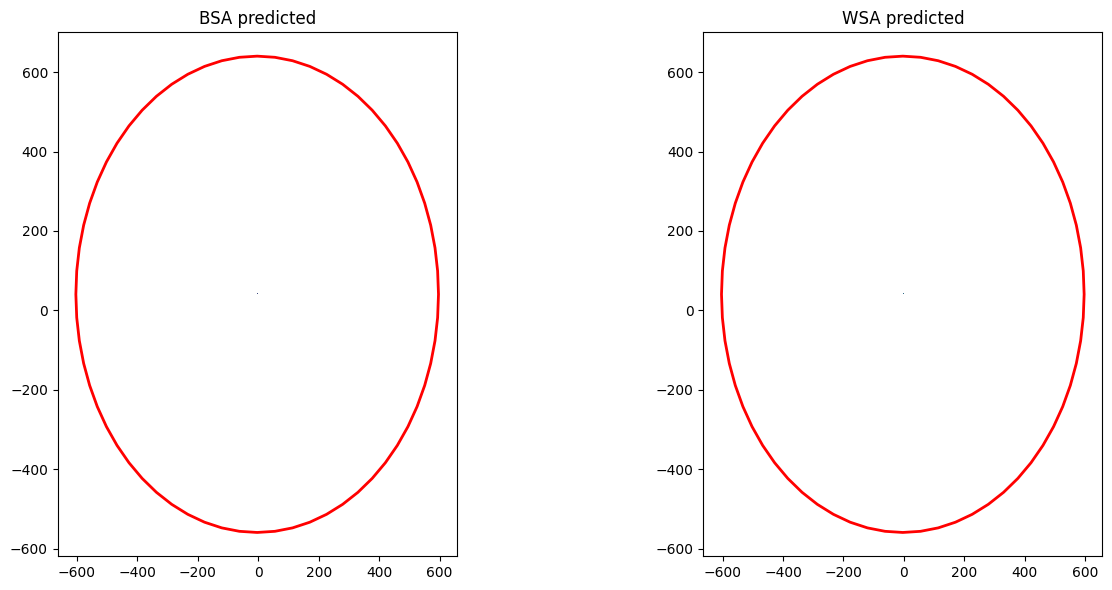

In [52]:
# %%python
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

# Paths
WORKDIR = '/content/sentinel_modis_albedo'
EXPORT_TIFF_NAME = 's2_bsa_wsa_pred.tif'
pred_path = os.path.join(WORKDIR, EXPORT_TIFF_NAME)

# AOI: point + buffer
POINT_LAT = 40.4168
POINT_LON = -3.7038
BUFFER_M = 600  # meters

if os.path.exists(pred_path):
    with rasterio.open(pred_path) as src:
        # Leer bandas
        bsa = src.read(1)
        wsa = src.read(2)
        meta = src.meta.copy()

        # Crear GeoDataFrame del AOI
        aoi_point = gpd.GeoDataFrame({'geometry':[Point(POINT_LON, POINT_LAT)]},
                                     crs='EPSG:4326')
        # Reproyectar al CRS del raster
        aoi_point = aoi_point.to_crs(src.crs)
        aoi_buffer = aoi_point.buffer(BUFFER_M)

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(14,6))

        # BSA
        show(bsa, transform=src.transform, ax=axs[0], cmap='viridis')
        axs[0].set_title('BSA predicted')
        aoi_buffer.plot(ax=axs[0], facecolor='none', edgecolor='red', linewidth=2)

        # WSA
        show(wsa, transform=src.transform, ax=axs[1], cmap='viridis')
        axs[1].set_title('WSA predicted')
        aoi_buffer.plot(ax=axs[1], facecolor='none', edgecolor='red', linewidth=2)

        plt.tight_layout()
        plt.show()
else:
    print(f"No se encontró el GeoTIFF de predicción en {pred_path}. Ejecuta la celda de predicción primero.")



/tmp/ipython-input-2154256454.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)



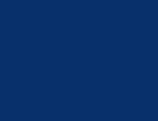
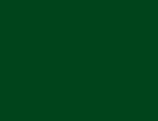

In [53]:
import folium
import numpy as np
import rasterio
from matplotlib import cm
from matplotlib.colors import Normalize
from PIL import Image
import os
from IPython.display import display

pred_path = os.path.join(WORKDIR, EXPORT_TIFF_NAME)

with rasterio.open(pred_path) as src:
    bsa = src.read(1)
    wsa = src.read(2)
    bounds = src.bounds

# Función para convertir raster a PNG y guardar en disco
def raster_to_png_file(data, out_path, cmap_name='viridis', vmin=None, vmax=None):
    if vmin is None: vmin = np.nanmin(data)
    if vmax is None: vmax = np.nanmax(data)
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgba_img = cmap(norm(data))
    img = Image.fromarray((rgba_img[:, :, :3]*255).astype(np.uint8))
    img.save(out_path)
    return out_path

# Guardar BSA y WSA como PNGs locales
bsa_png_path = os.path.join(WORKDIR, 'bsa.png')
wsa_png_path = os.path.join(WORKDIR, 'wsa.png')
raster_to_png_file(bsa, bsa_png_path, cmap_name='Blues', vmin=0, vmax=0.5)
raster_to_png_file(wsa, wsa_png_path, cmap_name='Greens', vmin=0, vmax=0.5)

# Coordenadas del raster
img_bounds = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

# Crear mapa centrado
center_lat = (bounds.bottom + bounds.top) / 2
center_lon = (bounds.left + bounds.right) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# Añadir ImageOverlay para BSA y WSA
folium.raster_layers.ImageOverlay(
    image=bsa_png_path,
    bounds=img_bounds,
    name='BSA',
    opacity=0.6,
    interactive=True,
    cross_origin=False
).add_to(m)

folium.raster_layers.ImageOverlay(
    image=wsa_png_path,
    bounds=img_bounds,
    name='WSA',
    opacity=0.6,
    interactive=True,
    cross_origin=False
).add_to(m)

# Añadir control de capas
folium.LayerControl().add_to(m)
display(m)
